# CALL LIBRARIES FOR PREPARING MODEL

In [ ]:
!pip install ultralytics
import pandas as pd #data manipulation and analysis
import numpy as np #for numerical operation
import cv2 #for image preprocessing
import torch  #for building and training neural networks
import os #to interact with operating system
from PIL import Image #for manipulating and saving image files
from skimage import draw #for drawing shapes
import random #generating random selection
from pathlib import Path #provides an object-oriented interface for file system paths.
from ultralytics import YOLO # for object detection and image classification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install rasterio
from rasterio import features #provides functions and classes for working with vector features

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 28.6 MB/s eta 0:00:00


# GENERATE SAMPLES

In [ ]:
def create_positive_sample(path, img_size, min_radius): #to generate image having circle
    path.parent.mkdir(parents=True, exist_ok=True)

    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    center_x = random.randint(min_radius, (img_size - min_radius))
    center_y = random.randint(min_radius, (img_size - min_radius))
    max_radius = min(center_x, center_y, img_size - center_x, img_size - center_y)
    radius = random.randint(min_radius, max_radius)

    row_indxs, column_idxs = draw.ellipse(center_x, center_y, radius, radius, shape=arr.shape)

    arr[row_indxs, column_idxs] = 255

    im = Image.fromarray(arr)
    im.save(path)

def create_negative_sample(path, img_size): #to generate image not containing circle
    path.parent.mkdir(parents=True, exist_ok=True)

    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    im = Image.fromarray(arr)
    im.save(path)



In [ ]:
def create_images(data_root_path, train_num, val_num, test_num, img_size=640, min_radius=10): #generate the images through above function in proportionate manner
    data_root_path = Path(data_root_path)

    for i in range(train_num):
        create_positive_sample(data_root_path / 'train' / 'images' / f'1_img_{i}.png', img_size, min_radius)

    for i in range(val_num):
        create_positive_sample(data_root_path / 'val' / 'images' / f'1_img_{i}.png', img_size, min_radius)

    for i in range(test_num):
        create_positive_sample(data_root_path / 'test' / 'images' / f'1_img_{i}.png', img_size, min_radius)

    for i in range(int(0.1 * train_num)):
      create_negative_sample(data_root_path / 'train' / 'images' / f'0_img_{i}.png', img_size) #number of negative sample will be 10% of positive sample

    for i in range(int(0.1 * val_num)):
      create_negative_sample(data_root_path / 'val' / 'images' / f'0_img_{i}.png', img_size)

    for i in range(int(0.1 * test_num)):
      create_negative_sample(data_root_path / 'test' / 'images' / f'0_img_{i}.png', img_size)

create_images('trial_data', train_num=700, val_num=200, test_num=100, img_size=120, min_radius=10)

# CREATE LABEL TO DETECT CIRCLE

In [ ]:
def create_label(image_path, label_path):
    arr = np.asarray(Image.open(image_path))
    cords_list = list(features.shapes(arr, mask=(arr > 0)))
    # Check if the list is not empty before accessing its elements
    if cords_list:
        cords = cords_list[0][0]['coordinates'][0]
        label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])
        # Create the parent directory for the label_path
        label_path.parent.mkdir(parents=True, exist_ok=True)
        # Write the label_line to the file
        with label_path.open('w') as f:
            f.write(label_line)
        return label_line
    else:
        print("No shapes found.", image_path) #it ensures that the given image doesn't contain any shape
        return None

for images_dir_path in [Path(f'trial_data/{x}/images') for x in ['train', 'val', 'test']]: #for each and every file, we will verify whether image is labeled or not.
    for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)
        if label_line:
            print(f"Label file saved for {img_path}")
        else:
            print(f"Label file not saved for {img_path}")



Label file saved for trial_data/train/images/1_img_292.png
Label file saved for trial_data/train/images/1_img_534.png
Label file saved for trial_data/train/images/1_img_172.png
Label file saved for trial_data/train/images/1_img_146.png
Label file saved for trial_data/train/images/1_img_300.png
Label file saved for trial_data/train/images/1_img_66.png
Label file saved for trial_data/train/images/1_img_142.png
Label file saved for trial_data/train/images/1_img_604.png
Label file saved for trial_data/train/images/1_img_442.png
Label file saved for trial_data/train/images/1_img_271.png
Label file saved for trial_data/train/images/1_img_577.png
Label file saved for trial_data/train/images/1_img_225.png
Label file saved for trial_data/train/images/1_img_160.png
Label file saved for trial_data/train/images/1_img_469.png
Label file saved for trial_data/train/images/1_img_372.png
Label file saved for trial_data/train/images/1_img_505.png
Label file saved for trial_data/train/images/1_img_346.pn

# MODEL PARAMETERS & TRAINING & YAML FILE PREPARATION

In [ ]:
yaml_content = f'''
train: /content/trial_data/train/images
val: /content/trial_data/val/images
test: /content/trial_data/test/images

names: ['circle']
    '''

with Path('data.yaml').open('w') as f:
    f.write(yaml_content) #create yaml file for model detection for each section i.e. training,validation and testing

In [ ]:
model = YOLO("/content/yolov8s.pt")
results = model.train(
        batch=8, #batch-size
        device="cpu",
        data="/content/data.yaml",
        epochs=7, #epochs
        imgsz=120, #Image size
    )

100%|██████████| 21.5M/21.5M [00:00<00:00, 162MB/s]


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/yolov8s.pt, data=/content/data.yaml, epochs=7, patience=50, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript

100%|██████████| 755k/755k [00:00<00:00, 19.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

train: Scanning /content/trial_data/train/labels... 700 images, 70 backgrounds, 0 corrupt: 100%|██████████| 770/770 [00:00<00:00, 1176.90it/s]


train: New cache created: /content/trial_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/trial_data/val/labels... 200 images, 20 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<00:00, 1266.07it/s]

val: New cache created: /content/trial_data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G     0.6273     0.6164     0.8682          2        128: 100%|██████████| 97/97 [01:36<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]

                   all        220        200          1          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G     0.5881     0.4386     0.8746          2        128: 100%|██████████| 97/97 [01:31<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]

                   all        220        200      0.999          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/7         0G     0.5414     0.4094     0.8692          2        128: 100%|██████████| 97/97 [01:31<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.17it/s]

                   all        220        200          1          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/7         0G      0.465     0.3452     0.8531          5        128: 100%|██████████| 97/97 [01:29<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.17it/s]

                   all        220        200          1          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/7         0G     0.4474     0.3324     0.8441          1        128: 100%|██████████| 97/97 [01:31<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]

                   all        220        200          1          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G     0.4275     0.3202     0.8427          2        128: 100%|██████████| 97/97 [01:30<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]

                   all        220        200          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/7         0G     0.3801     0.2898     0.8453          4        128: 100%|██████████| 97/97 [01:30<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]

                   all        220        200          1          1      0.995      0.977



7 epochs completed in 0.206 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


                   all        220        200          1          1      0.995      0.977
Speed: 0.2ms preprocess, 54.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


# RESULT

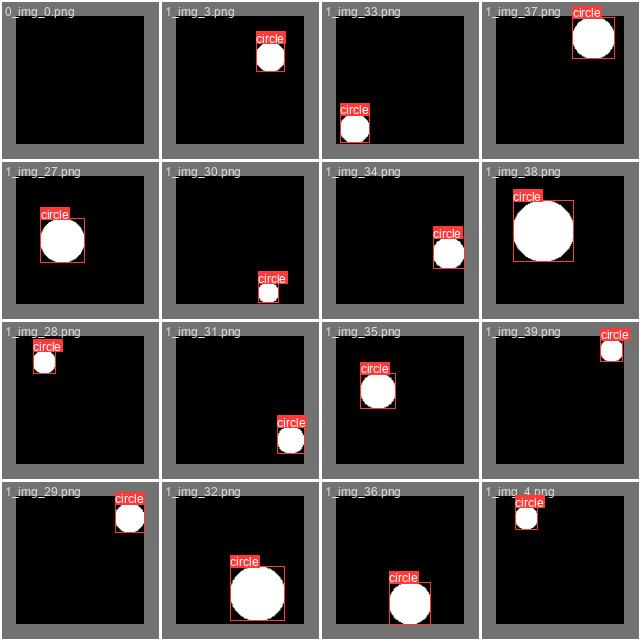

In [ ]:
from IPython.display import Image as show_image
show_image(filename="/content/runs/detect/train/val_batch0_labels.jpg") #to see if the model has able to detect circle or not.

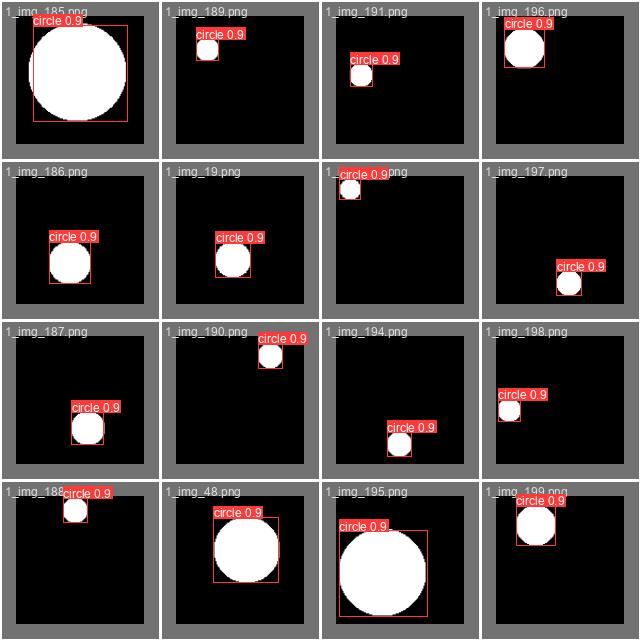

In [ ]:
from IPython.display import Image as show_image
show_image(filename="/content/runs/detect/train/val_batch2_pred.jpg")

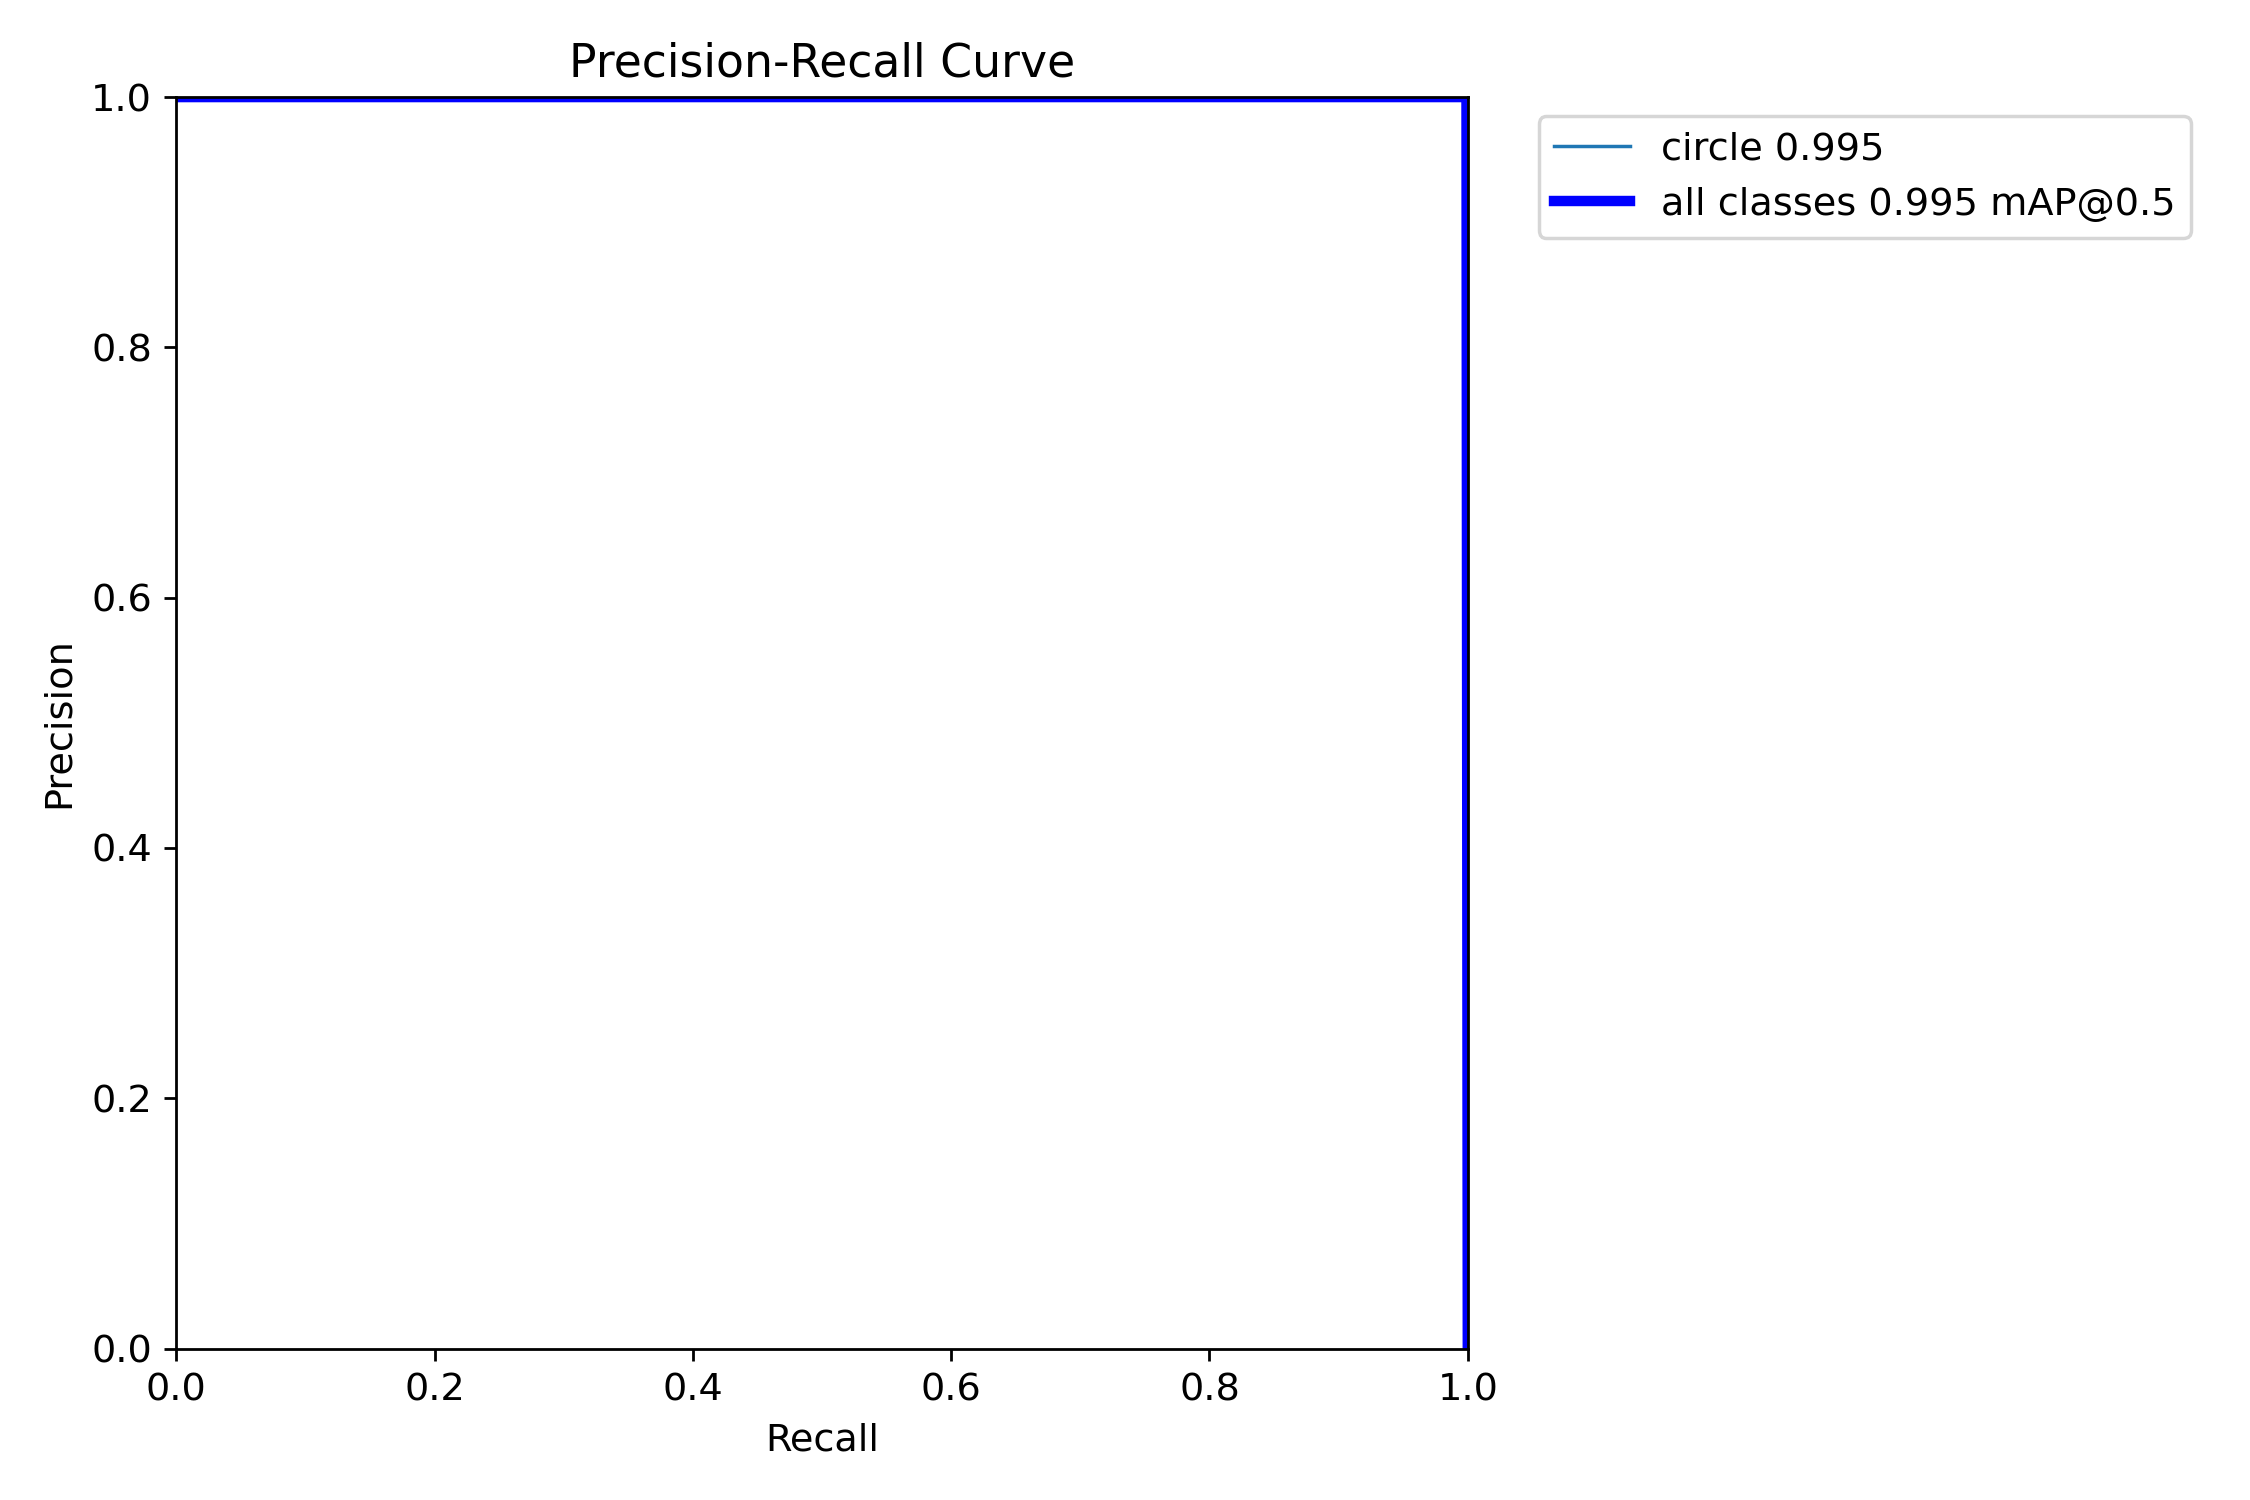

In [ ]:
#P-R Curve
show_image(filename="/content/runs/detect/train/PR_curve.png")

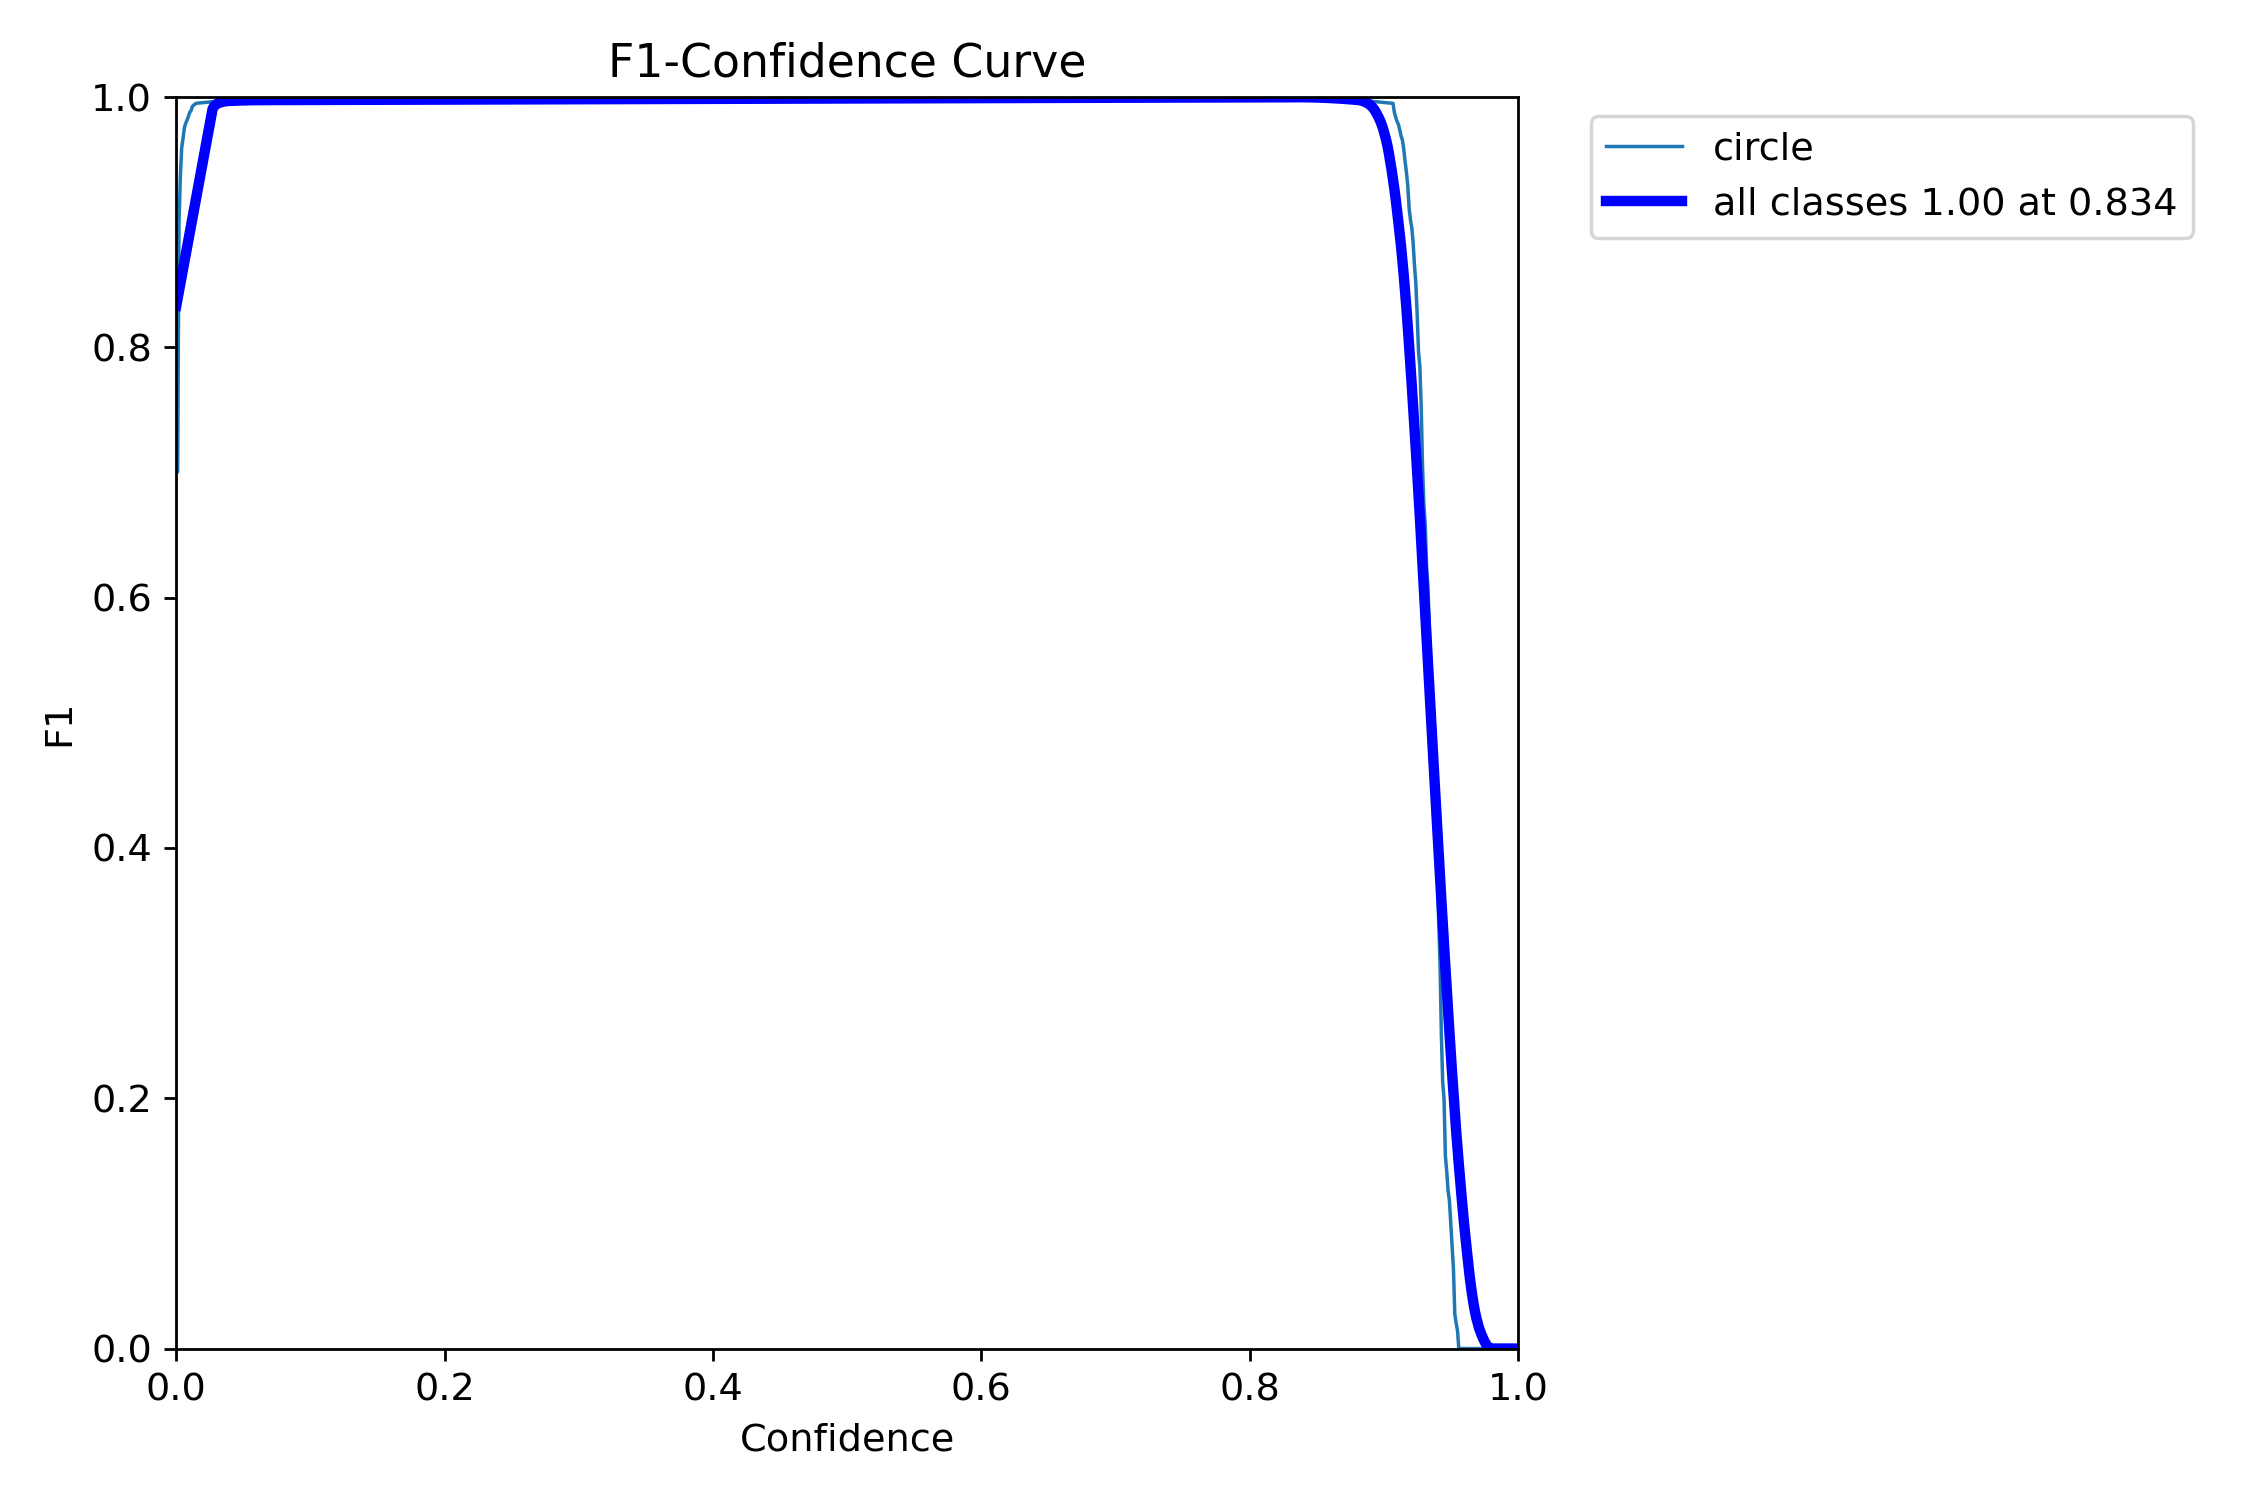

In [ ]:
#F1 - Confidence Curve
show_image(filename='/content/runs/detect/train/F1_curve.png')

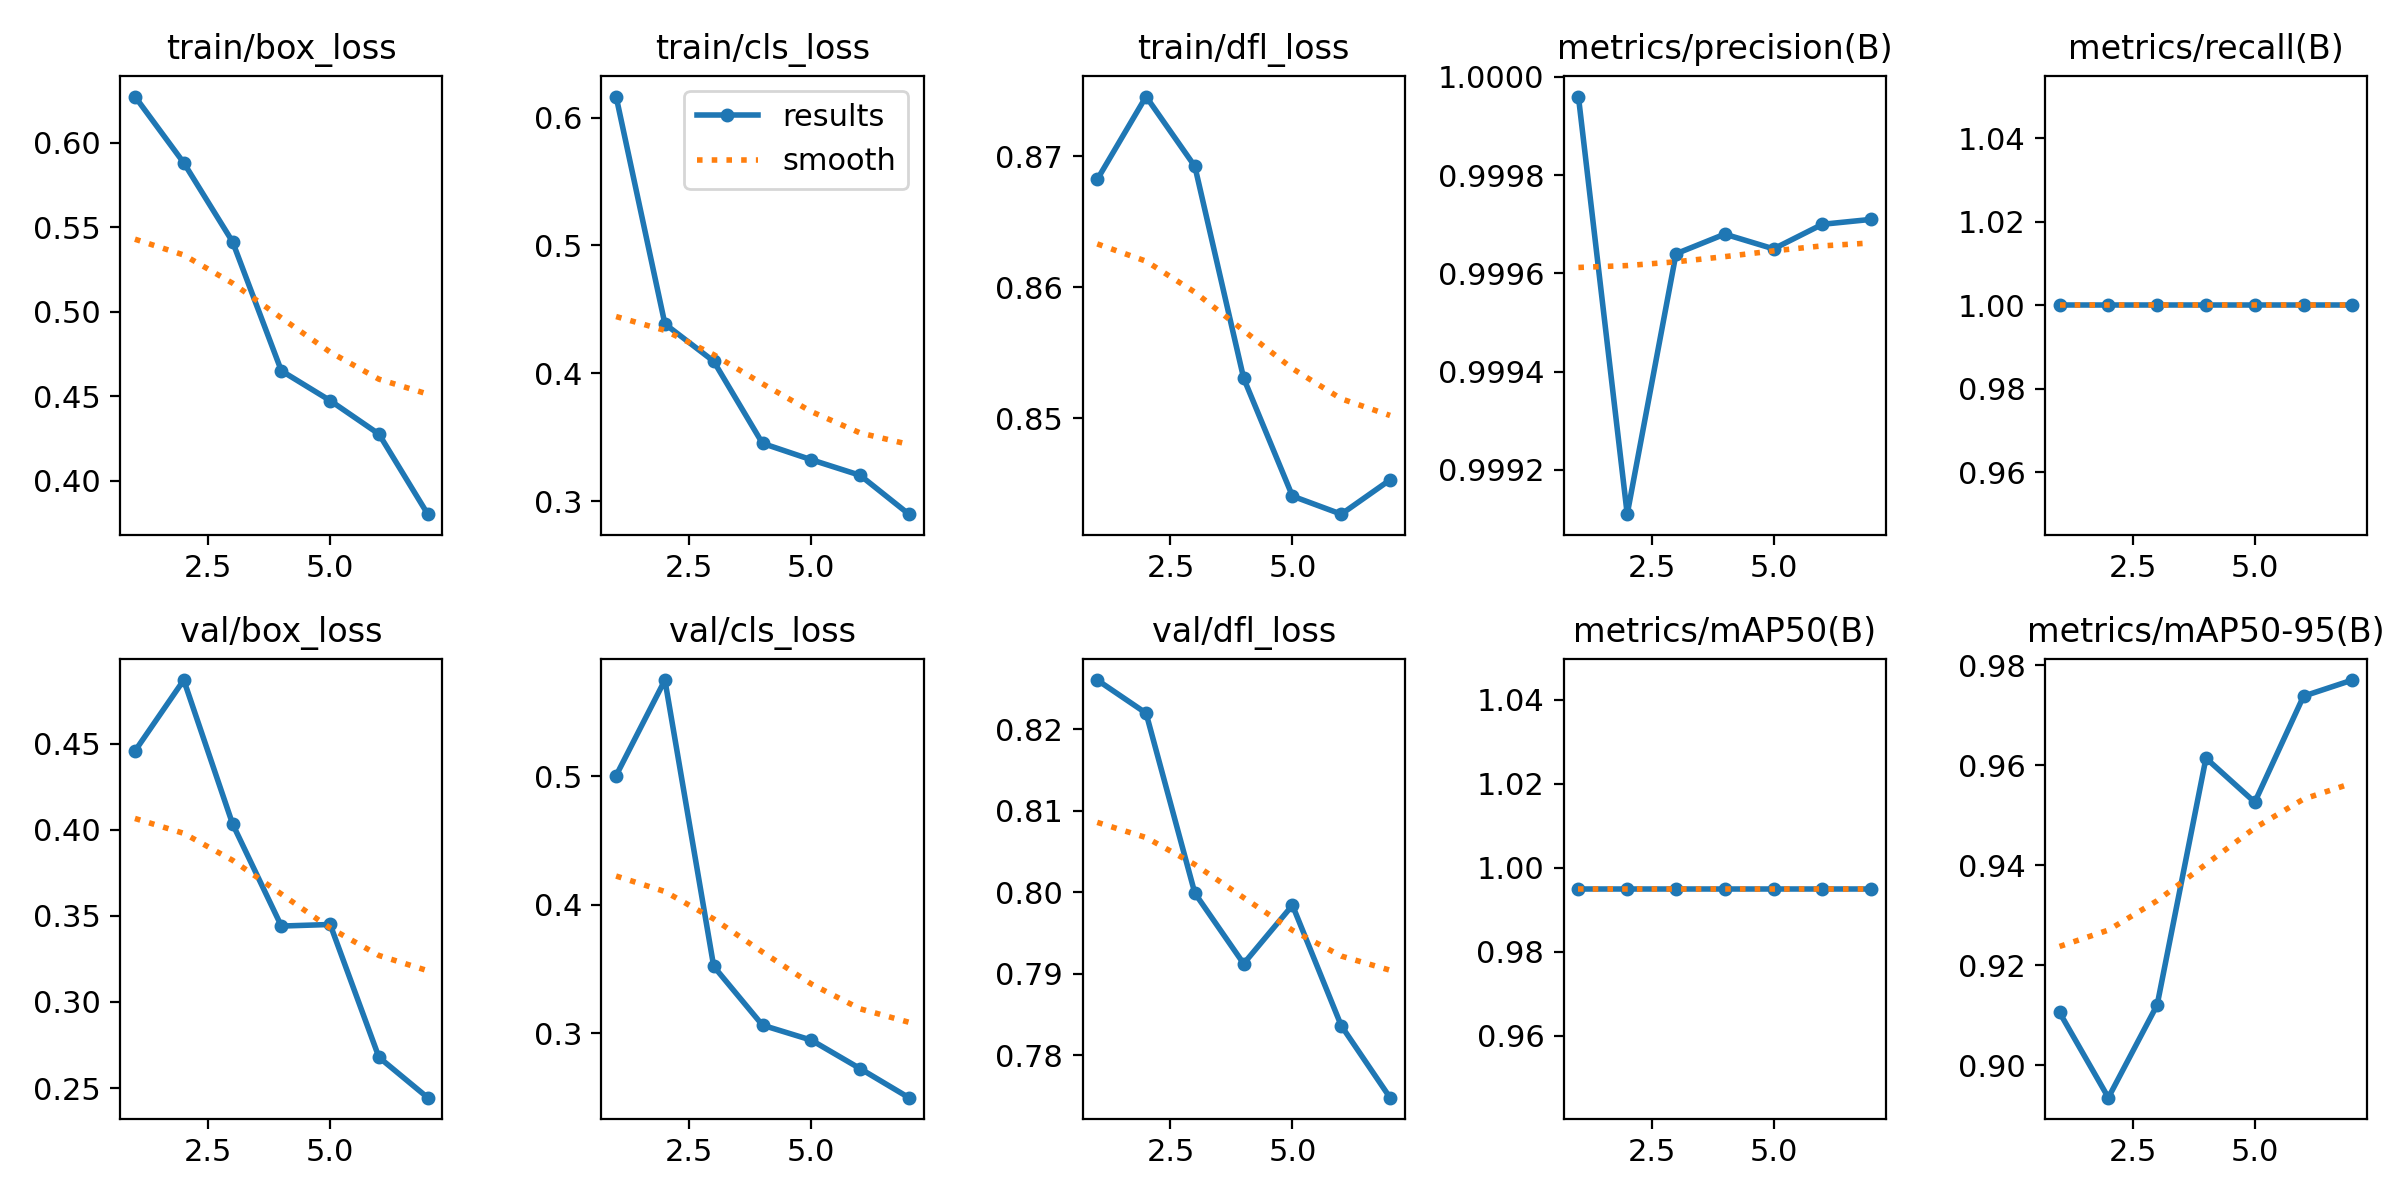

In [ ]:
show_image(filename="/content/runs/detect/train/results.png")

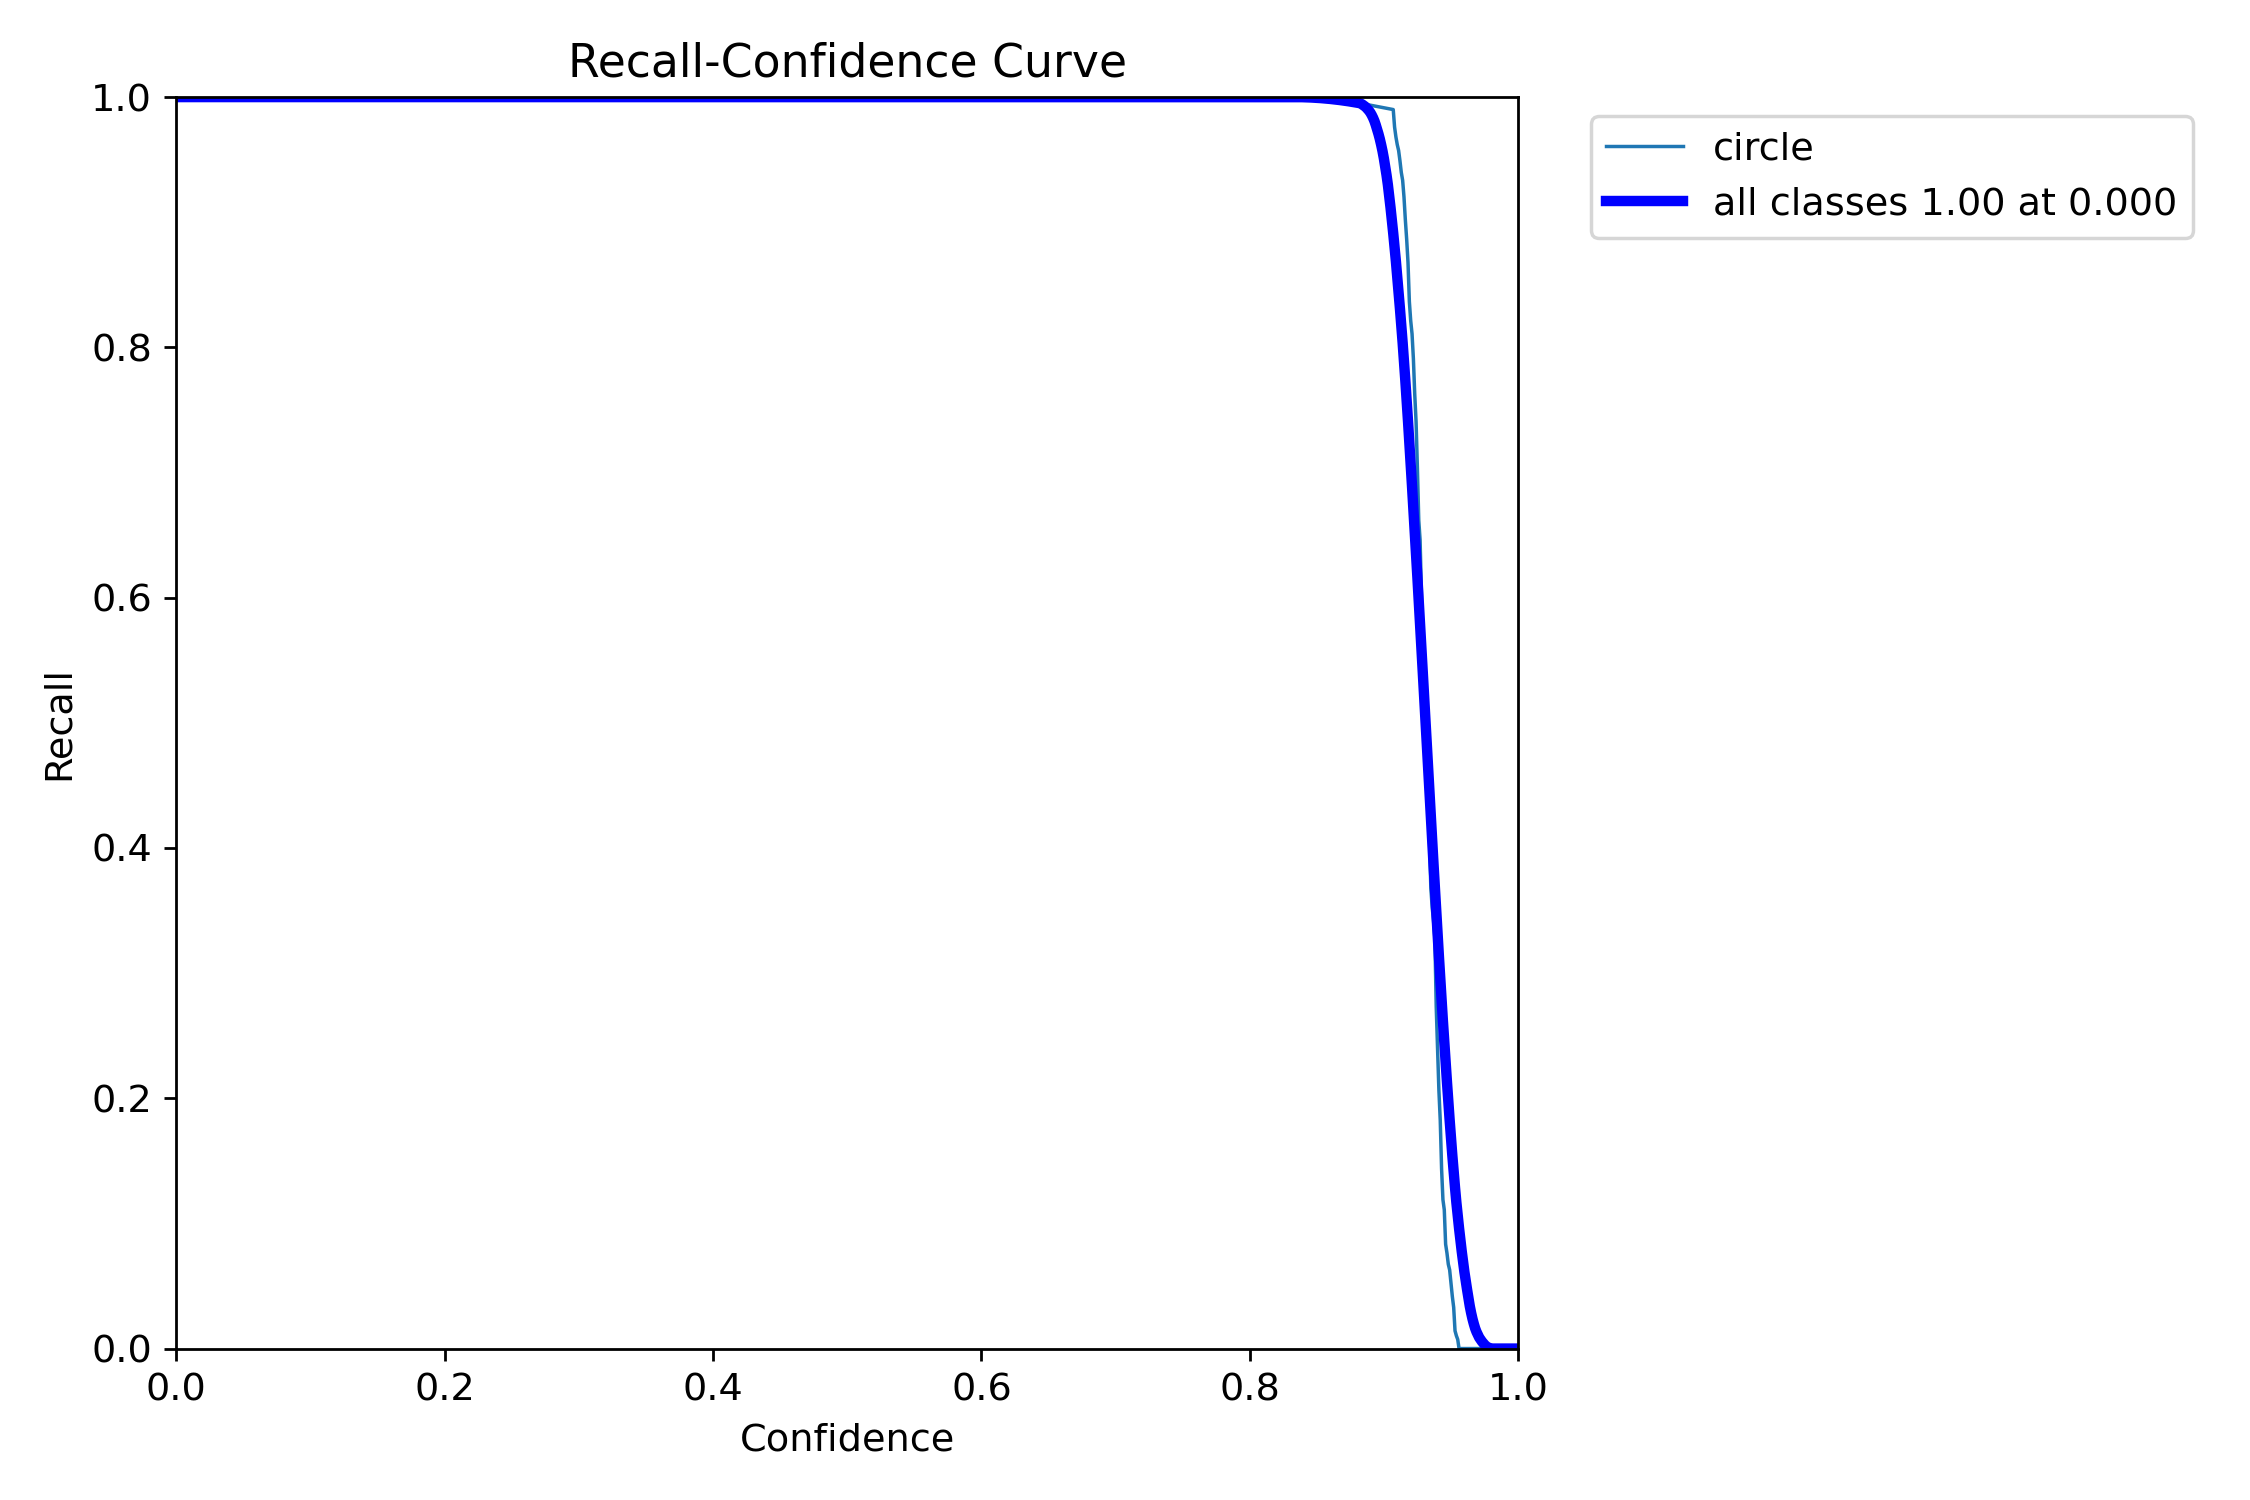

In [ ]:
show_image(filename='/content/runs/detect/train/R_curve.png') #recall confidence curve

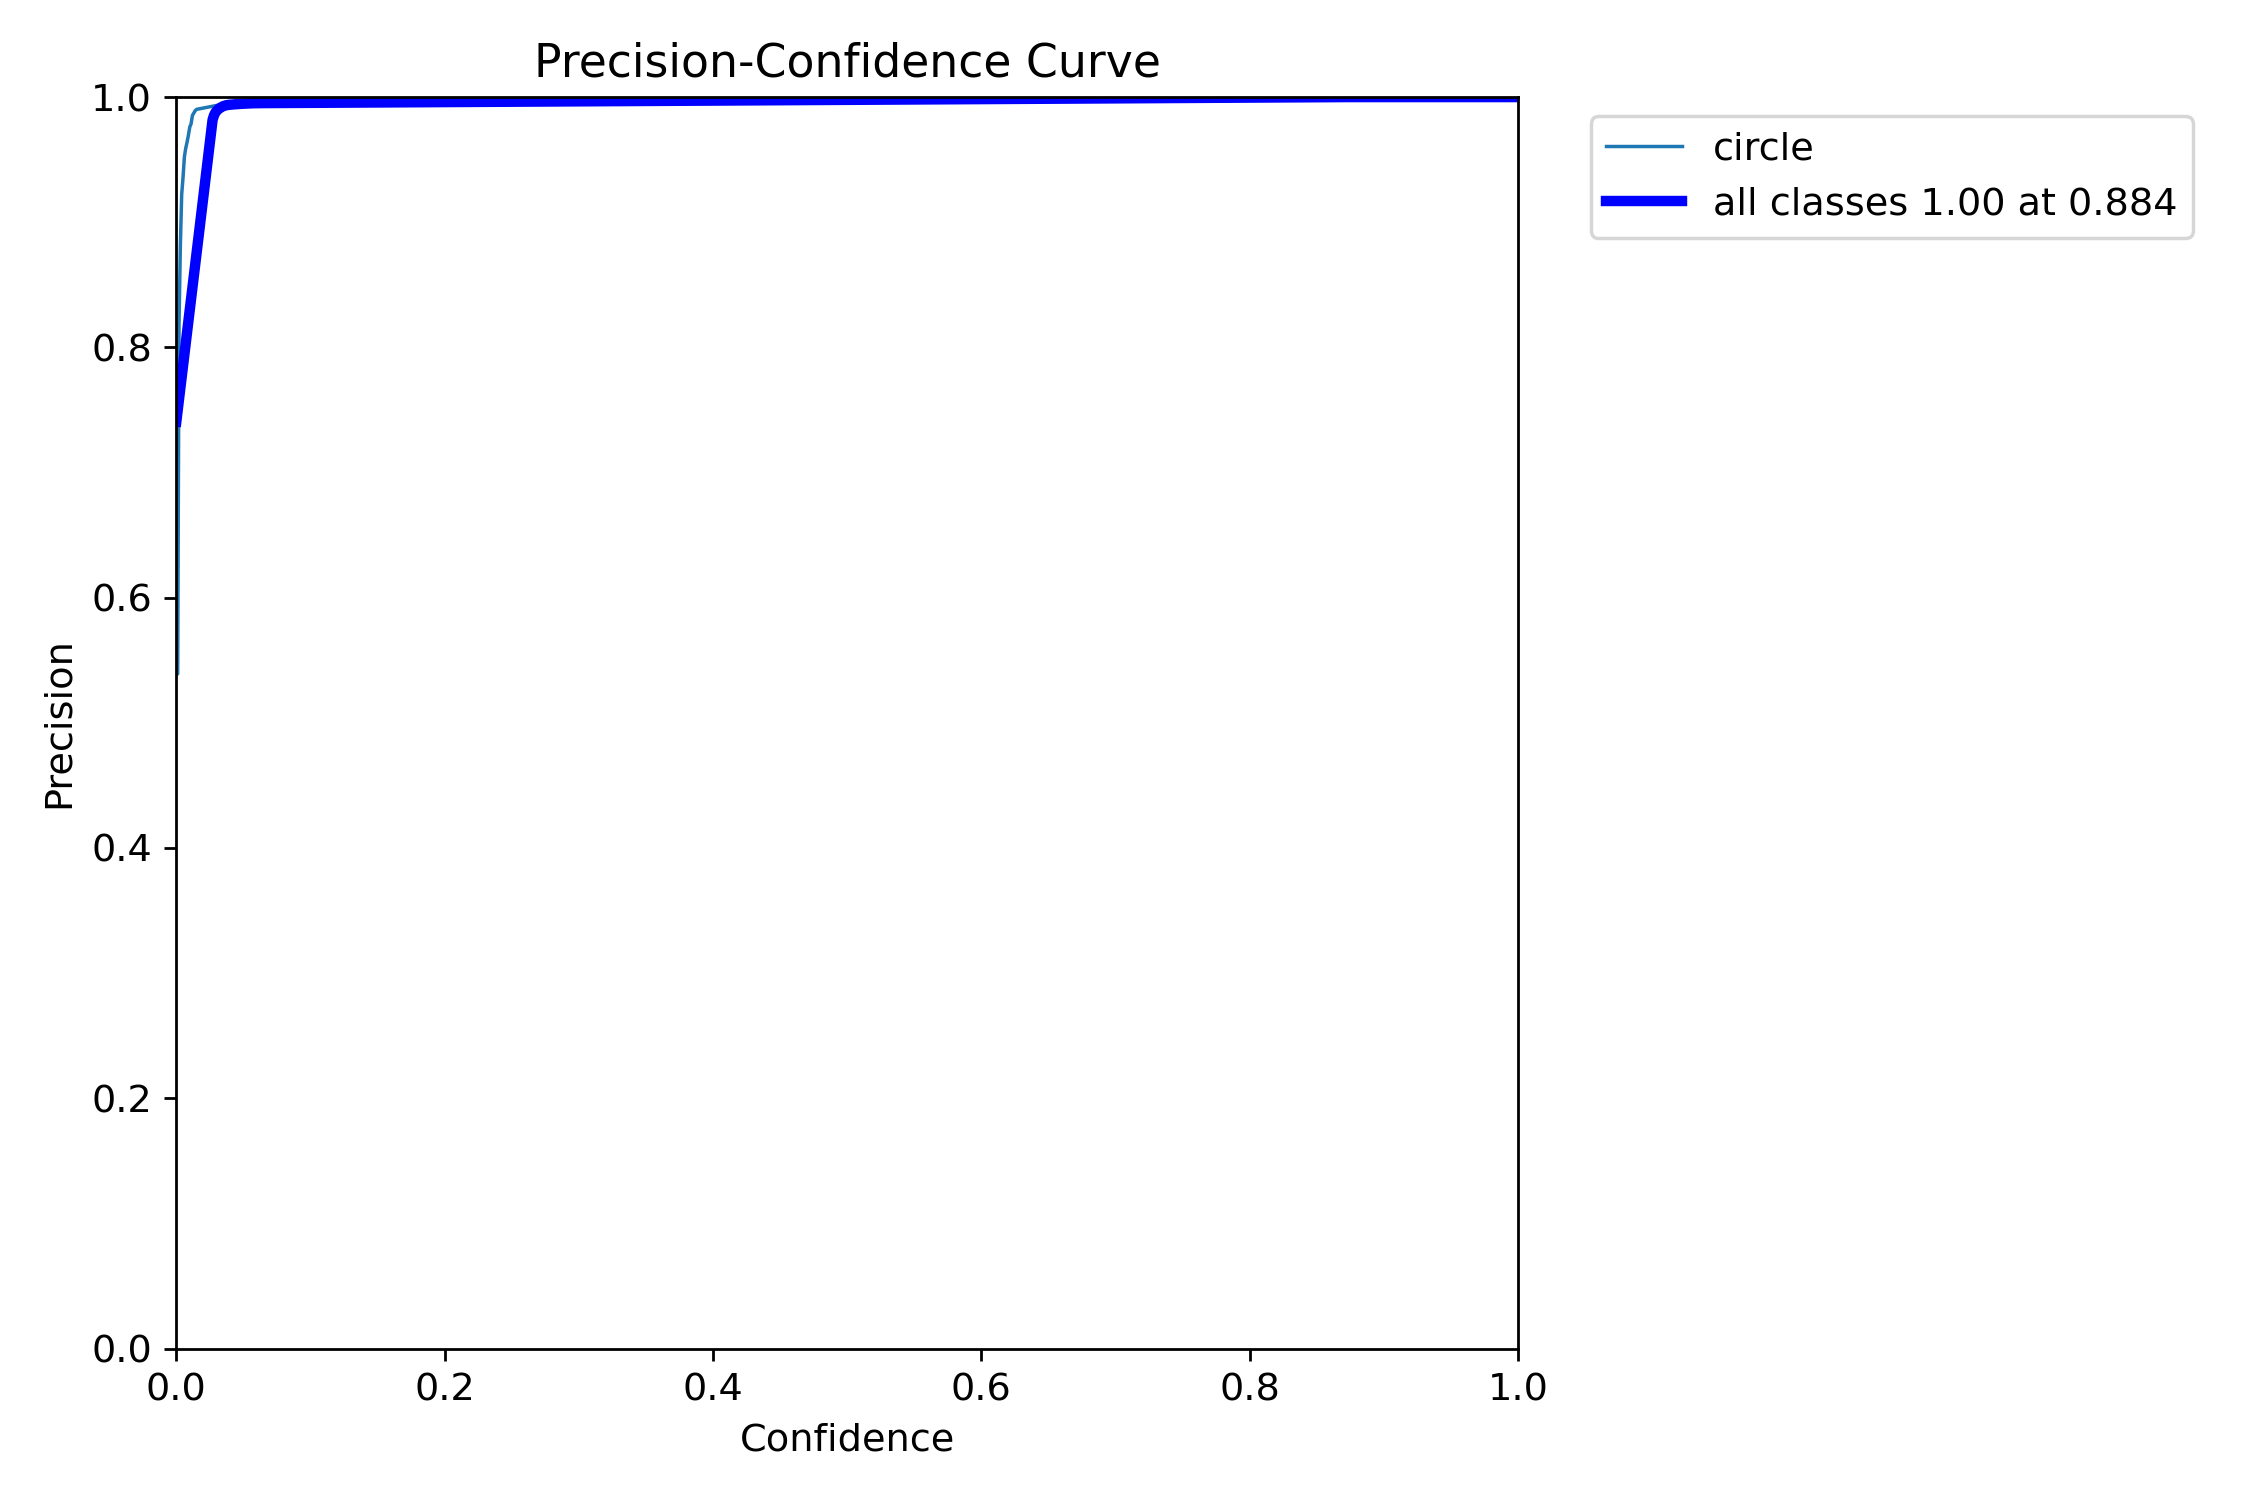

In [ ]:
show_image(filename='/content/runs/detect/train/P_curve.png') #precision score graph

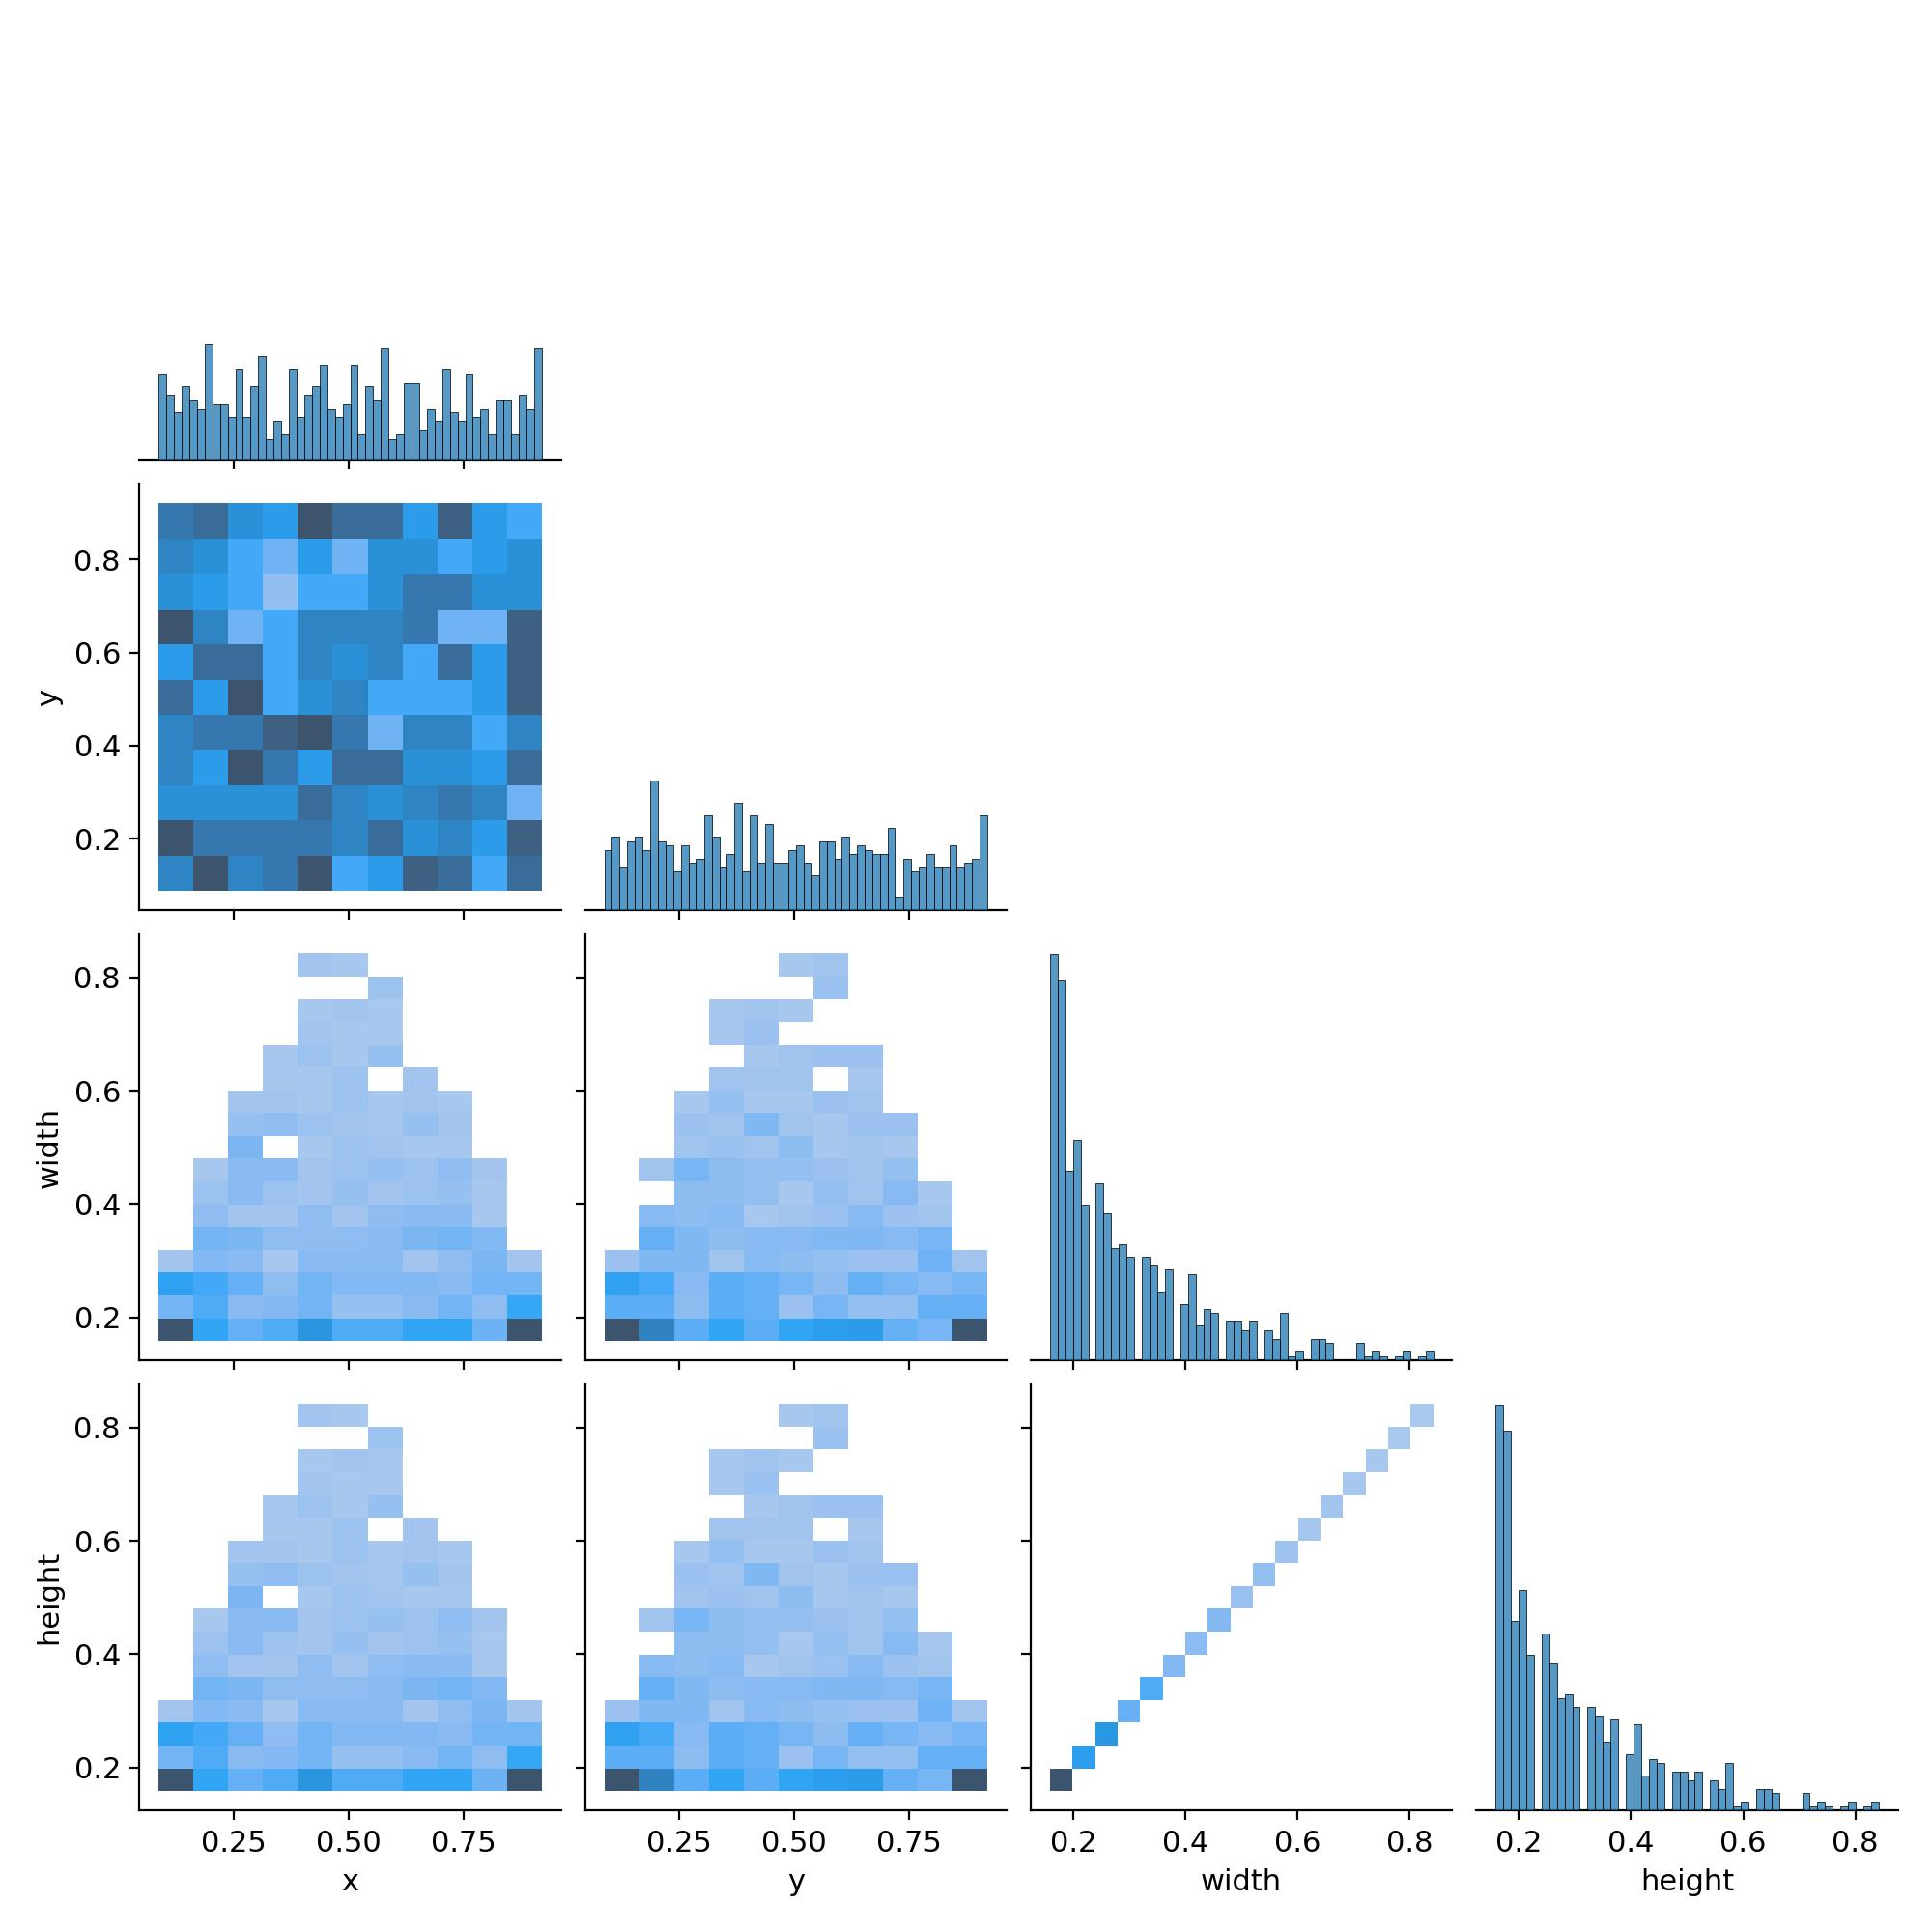

In [ ]:
show_image(filename='/content/runs/detect/train/labels_correlogram.jpg')

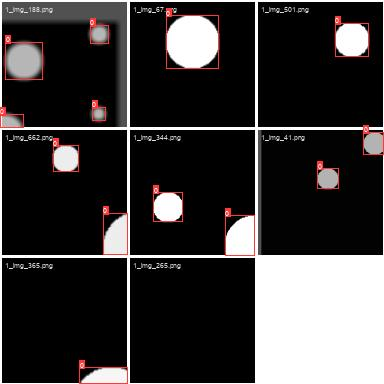

In [ ]:
show_image(filename='/content/runs/detect/train/train_batch1.jpg')

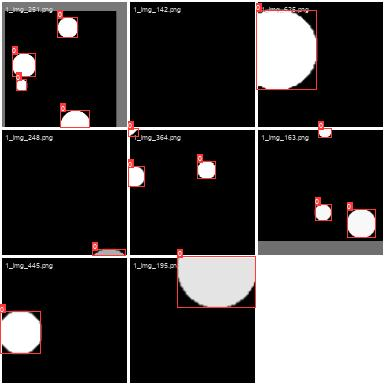

In [ ]:
show_image(filename='/content/runs/detect/train/train_batch2.jpg')

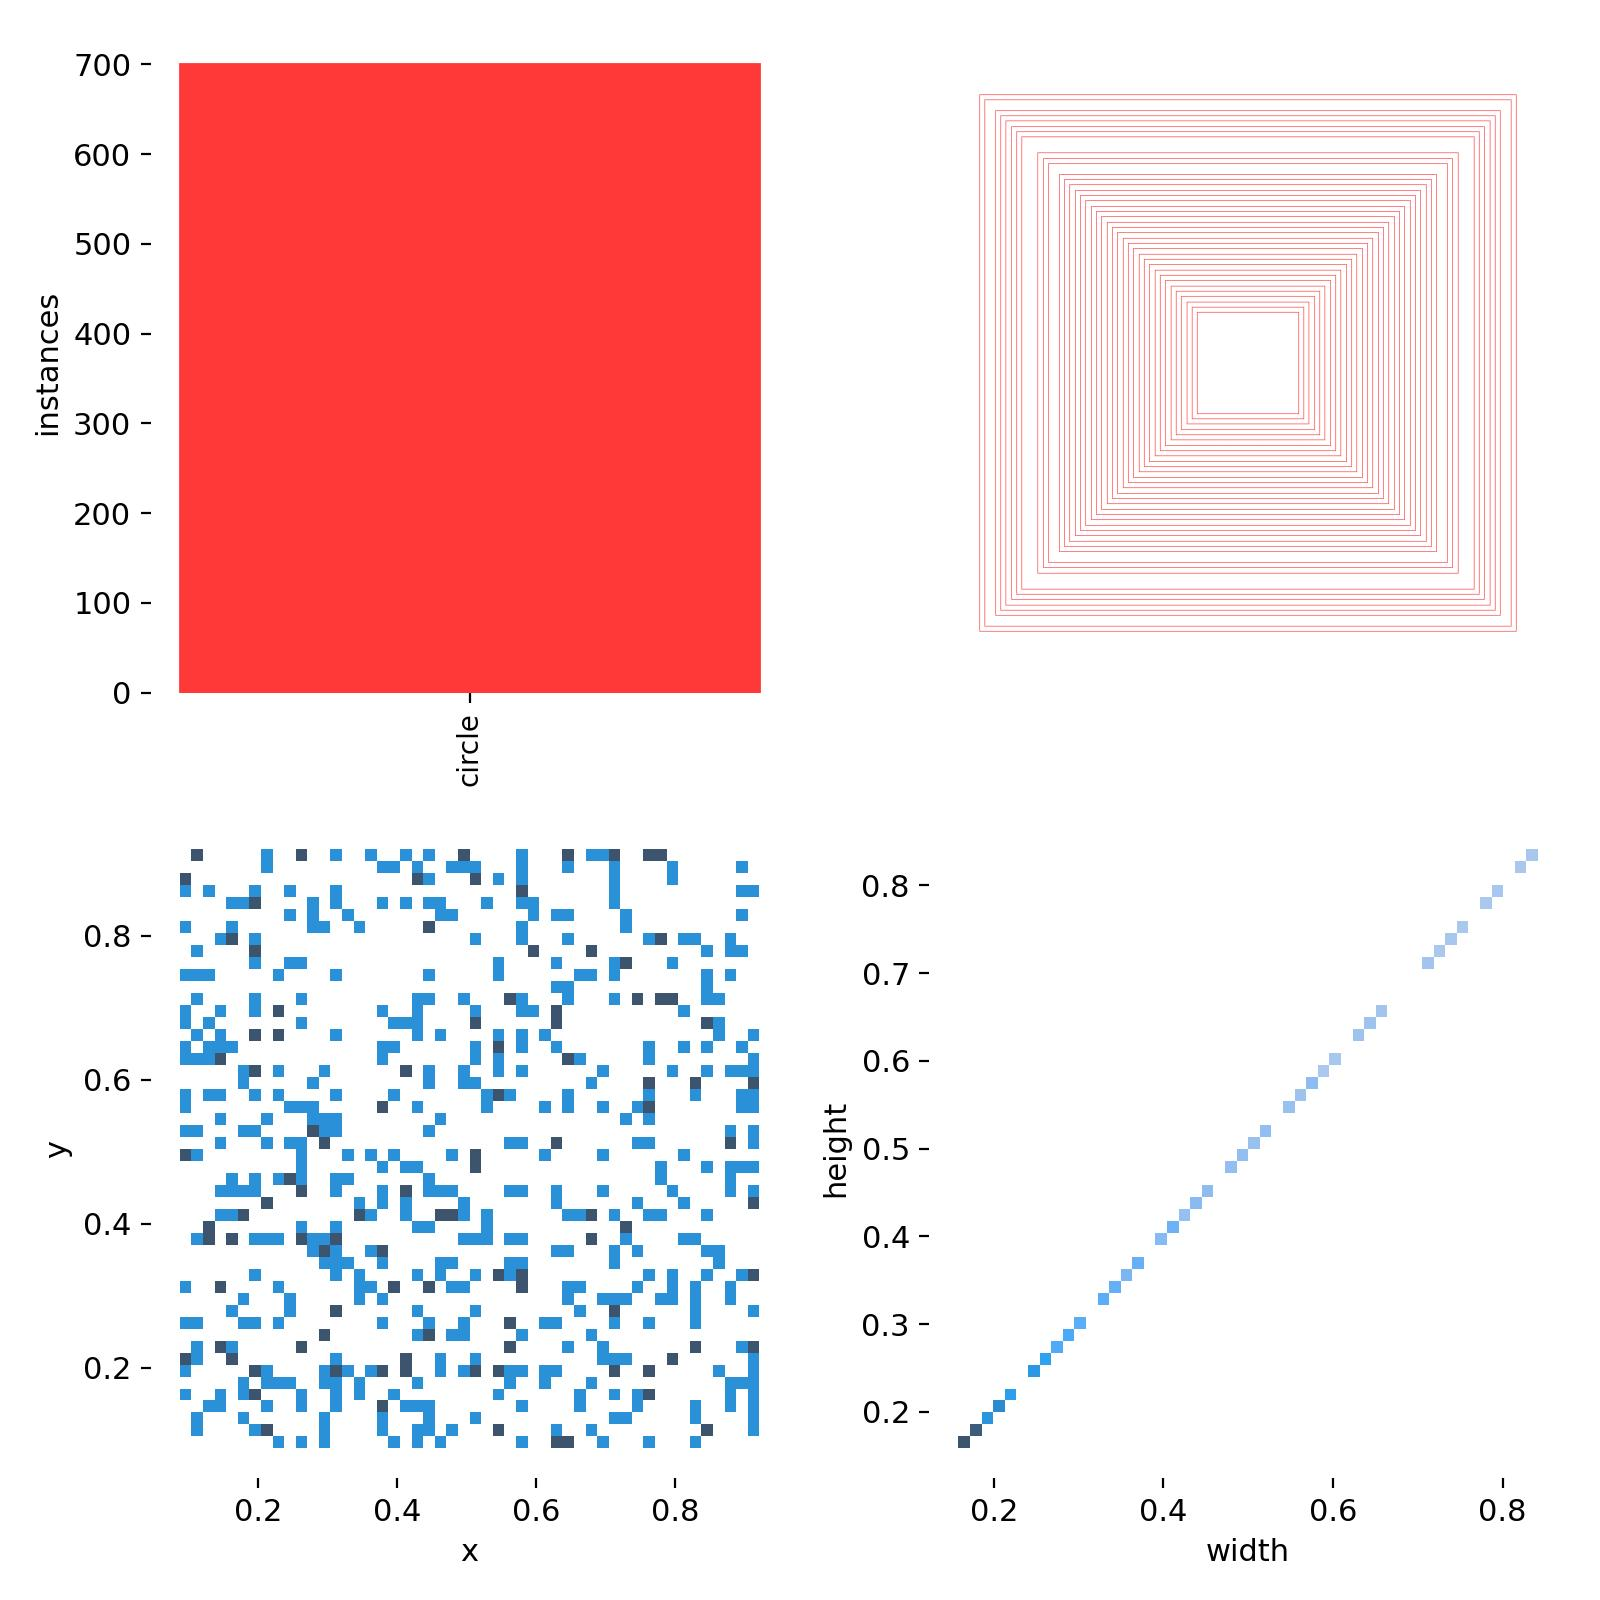

In [ ]:
show_image(filename='/content/runs/detect/train/labels.jpg')